# Notebook for training NN to reconstruct energy

In [3]:
import torch
import numpy as np
import pandas as pd
import uproot as up
from reco import process_data
from util import Classifier, train, test, plot_roc_curve
from IPython.display import clear_output
import matplotlib.pyplot as plot

In [4]:
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
in_dim = 28
out_dim = 1
num_epochs = 1
batch_size = 100

In [18]:
from reco import create_unique_mapping,get_layer,super_layer_map,calculate_num_pixels_z_dependence
def get_p(px,py,pz):
    sq = pow(px,2) + pow(py,2) + pow(pz,2)
    return pow(sq,0.5)
def process_data_energy_reco(uproot_path, file_num=0, particle="pion"):
    num_layers = 28
    events = up.open(uproot_path)
    
    x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
    z_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.z"].array(library='np')
    EDep_branch = events["HcalBarrelHits.EDep"].array(library='np')
    PDG_branch = events["MCParticles.PDG"].array(library='np')
    mc_px = events["MCParticles.momentum.x"].array(library='np')
    mc_py = events["MCParticles.momentum.y"].array(library='np')
    mc_pz = events["MCParticles.momentum.z"].array(library='np')
    x_momentum_branch = events["HcalBarrelHits/HcalBarrelHits.momentum.x"].array(library='np')
    y_momentum_branch = events["HcalBarrelHits/HcalBarrelHits.momentum.y"].array(library='np')
    z_momentum_branch = events["HcalBarrelHits/HcalBarrelHits.momentum.z"].array(library='np')
    Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')
    time_branch = events["HcalBarrelHits.time"].array(library='np')   
    num_events = len(x_pos_branch)
    data = torch.empty(num_events,2 * num_layers + 1)
    for event_idx in range(num_events):
        clear_output(wait=True)
        print(f"Event #{event_idx}")
        primary_momentum = get_p(mc_px[event_idx][0],mc_py[event_idx][0],mc_pz[event_idx][0])
        
        Hits_MC_idx_event = Hits_MC_idx_branch[event_idx]
        PDG_event = PDG_branch[event_idx]
        n_unique_parts, idx_dict = create_unique_mapping(Hits_MC_idx_event)
        
        z_hit_layer_list = np.ones((num_layers)) * -999
        edep_event = np.ones((num_layers)) * -999
        
        x_pos_event = x_pos_branch[event_idx]
        z_event = z_pos_branch[event_idx]
        EDep_event = EDep_branch[event_idx]
        
        time_event = time_branch[event_idx]
        event_layer_first_times = np.ones(28) * 9999
        event_layer_all_times = [[] for i in range(28)]
        for hit_idx in range(len(x_pos_event)):
            idx = Hits_MC_idx_branch[event_idx][hit_idx]
            layer_idx = get_layer(x_pos_event[hit_idx], super_layer_map)
            if layer_idx == -1: #error handling for get_layer
                continue
            event_layer_all_times[layer_idx].append(time_event[hit_idx])
            if edep_event[layer_idx] == -999:
                z_hit_layer_list[layer_idx] = z_event[hit_idx]
                edep_event[layer_idx] = EDep_event[hit_idx]
            else:
                edep_event[layer_idx] += EDep_event[hit_idx]
        for i in range(28):
            if(len(event_layer_all_times[i])):
                event_layer_first_times[i] = min(event_layer_all_times[i])
        data[event_idx][:28] = torch.tensor(np.floor(calculate_num_pixels_z_dependence(edep_event,z_hit_layer_list)).astype(int))
        data[event_idx][28:56] = torch.tensor(event_layer_first_times)
        data[event_idx][56] = primary_momentum
    data[data < 0] = 0
    return data #returns list: each entry is a diff event array; each event array has shape: (#unique particles, #layers, #features)

In [28]:
data_path = "/cwork/rck32/eic/work_eic/root_files/August_7/sector_scint/run_1_n_0_8_10GeV_theta_90_500kevents.edm4hep.root:events"
inputs = process_data_energy_reco(data_path)
data_size = len(inputs)

num_its = int(np.floor(data_size / batch_size))

Event #499999


In [29]:
indexes = torch.randperm(inputs.shape[0])
dataset = inputs[indexes]
train_frac = 0.8
test_frac = 0.1
val_frac = 0.1
train_lim = int(np.floor(dataset.shape[0] * train_frac))
test_lim = train_lim + int(np.floor(dataset.shape[0] * test_frac))
val_lim = test_lim + int(np.floor(dataset.shape[0] * val_frac))
train_data = dataset[:train_lim]
test_data = dataset[train_lim:test_lim]
val_data = dataset[test_lim:val_lim]

In [30]:
import torch.nn as nn
class Classifier(nn.Module):
    """
    Classifier for normalized tensors
    """
    def __init__(self, input_size=28, num_classes=2, hidden_dim = 512, num_layers = 10):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential()
        for i in range(num_layers):
            if(i == 0):
                self.layer.append(
                nn.Linear(input_size, hidden_dim)
                )
                self.layer.append(
                    nn.LeakyReLU(inplace=True)
                )
            elif(i == num_layers - 1):
                self.layer.append(
                nn.Linear(hidden_dim, num_classes)
                )
            else:
                self.layer.append(
                    nn.Linear(hidden_dim, hidden_dim)
                )
                self.layer.append(
                    nn.LeakyReLU(inplace=True)
                )
        self.name = "Classifier"
#         self.double()
        
    def forward(self, h):
        c = self.layer(h)
        return c
    
    # @property
    def name(self):
        """
        Name of model.
        """
        return self.name

In [31]:
from tqdm import tqdm
def train(classifier, train_data,optimizer, num_epochs = 18, batch_size = 100, show_progress = True):
    max_index = train_data.shape[1] - 1
    
    criterion = nn.MSELoss()
    classifier.train()
    num_it = train_data.shape[0] // batch_size

    show_progress = True
    loss_hist = []
    curr_losses = []
    for i in range(num_epochs):
        clear_output(wait=True)
        print(f"Training epoch #{i}")
        epoch_hist = np.array([])
        val_epoch_hist = np.array([])
        with tqdm(total=num_it, position=0, leave=True) as pbar:
            for it in range(num_it):
                optimizer.zero_grad()
                begin = it * batch_size
                end = (it + 1) * batch_size
                it_data = train_data[begin:end]
                samples = it_data[:,:max_index]
                labels = it_data[:,max_index].unsqueeze(-1)
                samples = samples.to(device)
                labels = labels.to(device)
                outputs = classifier(samples)
                loss = criterion(outputs, labels)
                # Do backprop and optimizer step
                if ~(torch.isnan(loss) | torch.isinf(loss)):
                    loss.backward()
                    optimizer.step()
                # Log loss
                if~(torch.isnan(loss)):
                    curr_losses.append(loss.to('cpu').data.numpy())
                    if(not (it % 5)):
                        loss_hist.append(sum(curr_losses) / len(curr_losses))
                        curr_losses = []
                if(show_progress):
                    pbar.update(1)
        

    print('Finished Training')
    return loss_hist

In [45]:
model = Classifier(input_size=56, num_classes=1, hidden_dim = 512, num_layers = 20)
model = model.to(device)

In [50]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
loss_hist = train(model, train_data,optimizer, num_epochs = 8, batch_size = 100, show_progress = True)

Training epoch #1


100%|██████████| 4000/4000 [00:42<00:00, 95.17it/s] 

Finished Training


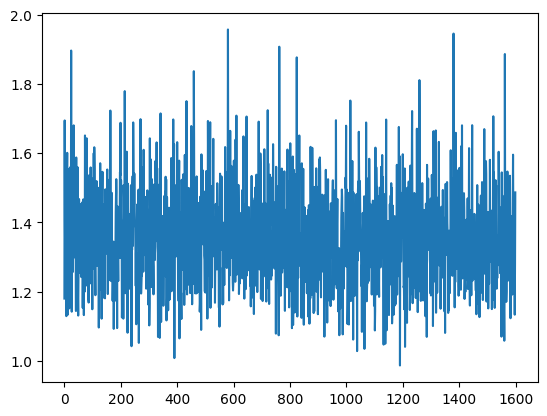

In [52]:
plot.plot(loss_hist)

In [60]:
def plot_predictions(true_values, predictions):
    plot.figure(figsize=(10, 6))
    plot.scatter(true_values, predictions, alpha=0.05)
    plot.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'r--', lw=2)
    plot.xlabel('True Values')
    plot.ylabel('Predictions')
    plot.title('True Values vs. Predictions')
    plot.tight_layout()
    plot.show()


In [61]:
import torch
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, test_data, device):
    model.eval()  # Set the model to evaluation mode
    max_index = test_data.shape[1] - 1
    
    with torch.no_grad():
        samples = test_data[:, :max_index].float().to(device)
        true_values = test_data[:, max_index].float().cpu().numpy()
        
        predictions = model(samples).cpu().numpy().flatten()
    
    # Calculate metrics
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predictions)
    
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"R-squared Score: {r2:.4f}")
    plot_predictions(true_values, predictions)
    return mae, mse, rmse, r2

Mean Absolute Error: 0.8640
Mean Squared Error: 1.3620
Root Mean Squared Error: 1.1670
R-squared Score: 0.8070


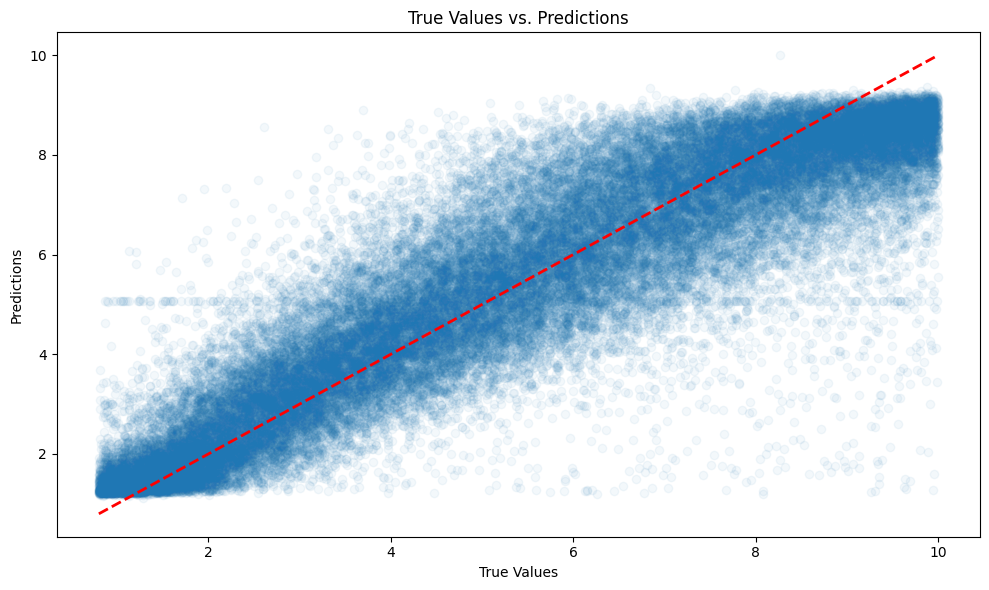

In [62]:
mae, mse, rmse, r2 = evaluate_model(model, test_data, device)